# Кластеризация
__Суммарное количество баллов: 10__

__Решение отправлять на `ml.course.practice@gmail.com`__

__Тема письма: `[ML][HW02] <ФИО>`, где вместо `<ФИО>` указаны фамилия и имя__

В этом домашнем задании предлагается реализовать три различных метода кластеризации, понять, в каких случаях стоит применять те или иные методы, а так же применить один из алгоритмов к задаче уменьшения цветности изображения.

In [1]:
from sklearn.neighbors import KDTree
from sklearn.datasets import make_blobs, make_moons, make_swiss_roll
import numpy as np
import random
import matplotlib.pyplot as plt
import matplotlib
import copy
from collections import deque
import cv2

In [13]:
universal_colors = np.random.random((500000, 3))
universal_colors[0] = [0, 0, 0]
universal_colors[1] = [1, 0, 0]
universal_colors[2] = [0, 1, 0]
universal_colors[3] = [0, 1, 1]


def visualize_clasters(X, labels):
    unique_labels = np.unique(labels)
    unique_colors = universal_colors[:len(unique_labels) + 1]
    colors = [unique_colors[l] for l in labels]
    plt.figure(figsize=(9, 9))
    plt.scatter(X[:, 0], X[:, 1], c=colors)
    plt.show()

def clusters_statistics(flatten_image, cluster_colors, cluster_labels):
    fig, axes = plt.subplots(3, 2, figsize=(12, 16))
    for remove_color in range(3):
        axes_pair = axes[remove_color]
        first_color = 0 if remove_color != 0 else 2
        second_color = 1 if remove_color != 1 else 2
        axes_pair[0].scatter([p[first_color] for p in flatten_image], [p[second_color] for p in flatten_image], c=flatten_image, marker='.')
        axes_pair[1].scatter([p[first_color] for p in flatten_image], [p[second_color] for p in flatten_image], c=[cluster_colors[c] for c in cluster_labels], marker='.')
        for a in axes_pair:
            a.set_xlim(0, 1)
            a.set_ylim(0, 1)
    plt.show()

Генерируем два синтетических набора данных для кластеризации. Далее будем тестировать наши алгоритмы на них.

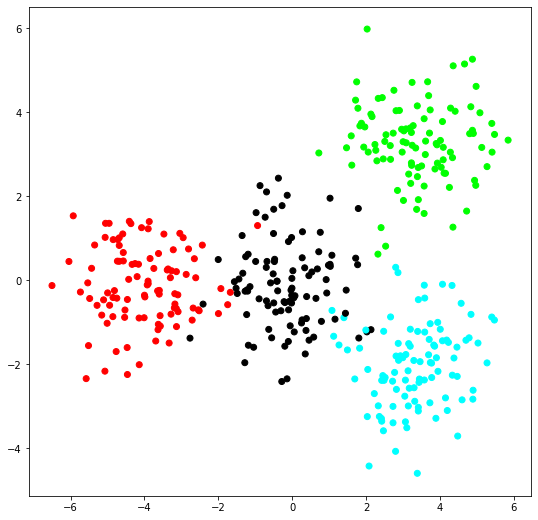

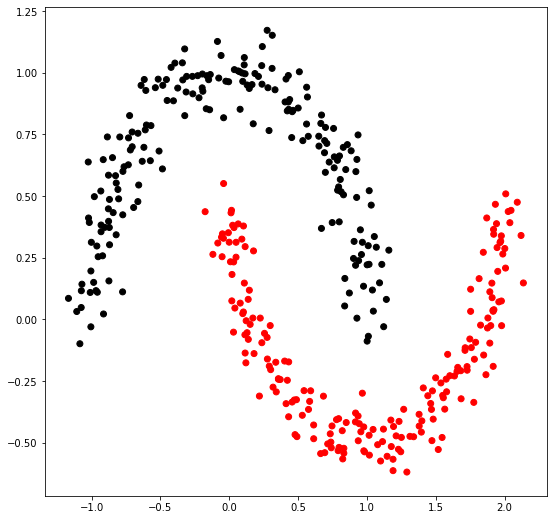

In [33]:
X_1, true_labels = make_blobs(400, 2, centers=[[0, 0], [-4, 0], [3.5, 3.5], [3.5, -2.0]])
visualize_clasters(X_1, true_labels)
X_2, true_labels = make_moons(400, noise=0.075)
visualize_clasters(X_2, true_labels)

### Задание 1 (3 балла)
Первый метод, который предлагается реализовать - метод K средних.

#### Описание методов
`fit(X, y=None)` ищет и запоминает в `self.centroids` центроиды кластеров для набора данных.
`predict(X)` для каждого элемента из `X` возвращает номер кластера, к которому относится данный элемент.

#### Инициализация кластеров
Есть несколько вариантов инициализации кластеров. Нужно реализовать их все:
1. `random` - центроиды кластеров являются случайными точками
2. `sample` - центроиды кластеров выбираются случайно из набора данных
3. `k-means++` - центроиды кластеров инициализируются при помощи метода K-means++

__Не забудте реинициализировать пустые кластеры!__

In [4]:

class KMeans:
    def __init__(self, n_clusters, init="k-means++", max_iter=300):
        self.n_clusters = n_clusters
        self.init = init
        self.max_iter = max_iter
        self.centroids = None
        self.tree = None
        self.X = None

    def random_centroids(self):
        dim = len(self.X[0])
        array = np.full((self.n_clusters, dim), 0)
        for i in range(dim):
            max_x = max(self.X[:, i])
            min_x = min(self.X[:, i])
            rand_x = (max_x - min_x) * np.random.random(self.n_clusters) + min_x
            array[:, i] = rand_x
        self.centroids = array

    def sample_centroids(self):
        random_indexes = np.random.randint(0, len(self.X), self.n_clusters)
        self.centroids = [self.X[ind] for ind in random_indexes]

    def kmeans_centroids(self):
        self.tree = KDTree(self.X)
        start_point = self.X[np.random.randint(0, len(self.X))]
        self.centroids = [start_point]
        distances = [np.linalg.norm(x - start_point) ** 2 for x in self.X]
        max_dist = max(distances)
        sum_of_distances = sum(distances)
        while len(self.centroids) < self.n_clusters:
            rand = np.random.random() * sum_of_distances
            next_centroid = 0
            temp_sum = 0
            while temp_sum < rand:
                temp_sum += distances[next_centroid]
                if temp_sum < rand:
                    next_centroid += 1
            self.centroids.append(self.X[next_centroid])
            to_update = self.tree.query_radius(np.array([self.centroids[-1]]), max_dist)[0]
            for ind in to_update:
                current_dist = (np.linalg.norm(
                    self.X[ind] - self.centroids[-1]) ** 2)
                old_dist = distances[ind]
                distances[ind] = min(old_dist, current_dist)
                sum_of_distances -= (old_dist - distances[ind])
            max_dist = max(distances)

    def update(self):
        sum_array = np.full((self.n_clusters, len(self.X[0])), 0.0)
        num_array = np.full((self.n_clusters, len(self.X[0])), 0)
        clusters = self.predict(self.X)
        flag = False
        for i in range(len(self.X)):
            cluster = clusters[i]
            sum_array[cluster] += self.X[i]
            num_array[cluster] += 1
        for i in range(len(num_array)):
            if num_array[i][0] == 0:
                flag = True
                self.centroids[i] = self.X[np.random.randint(0, len(self.X))]
        if flag:
            self.update()
        else:
            self.centroids = sum_array / num_array

    def fit(self, X, y=None):
        self.X = X
        if self.init == "random":
            self.random_centroids()
        elif self.init == "sample":
            self.sample_centroids()
        elif self.init == "k-means++":
            self.kmeans_centroids()
        for i in range(self.max_iter):
            self.update()

    def predict(self, X):
        return [np.argmin([np.linalg.norm(x - c) ** 2 for c in self.centroids]) for x in X]



Протестируйте алгоритм на синтетических данных. При необходимости подберите гиперпараметры для достижения лучшего качества кластеризации.

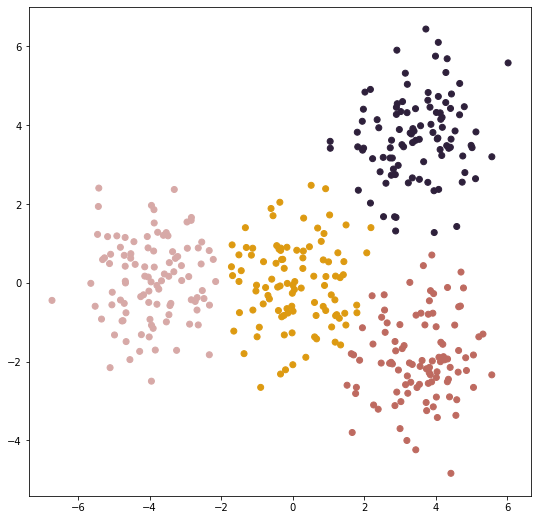

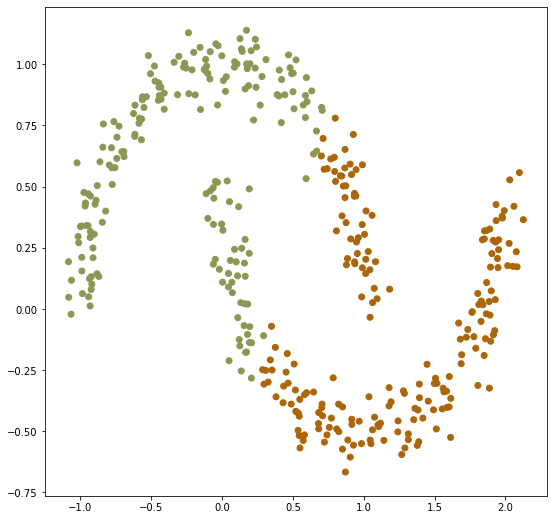

In [8]:
kmeans = KMeans(n_clusters=4)
kmeans.fit(X_1)
labels = kmeans.predict(X_1)
visualize_clasters(X_1, labels)

kmeans = KMeans(n_clusters=2)
kmeans.fit(X_2)
labels = kmeans.predict(X_2)
visualize_clasters(X_2, labels)

### Задание 2 (2 балла)
В отличии от K-means, DBScan не позволяет задать количество кластеров, на которое будут разбиты данные. Руководствуясь геометрической интерпретацией, он позволяет выделять кластеры более сложной формы.

#### Описание методов
`fit_predict(X, y=None)` для каждого элемента `X` возвращает метку кластера, к которому он относится.

#### Возможные метрики
* `euclidean`
* `manhattan`
* `chebyshev`

__Для быстрого поиска соседей используйте `sklearn.neighbors.KDTree`__

In [11]:
class DBScan:
    def __init__(self, eps=0.5, min_samples=5, leaf_size=40, metric="euclidean"):
        print("init")
        self.eps = eps
        self.min_samples = min_samples
        self.leaf_size = leaf_size
        self.metric = metric
        self.tree = None

    def fit_predict(self, X, y=None, show_density_only=False):
        self.tree = KDTree(X, self.leaf_size, self.metric)
        answer = np.full((len(X)), -1)
        clusters_number = 0
        if show_density_only:
            for i in range(len(X)):
                if answer[i] == -1:
                    neighbors = self.tree.query_radius([X[i]], self.eps)[0]
                    if len(neighbors) < self.min_samples:
                        answer[i] = 0
                    else:
                        answer[i] = 1
            return answer
        for i in range(len(X)):
            if answer[i] == -1:
                neighbors = self.tree.query_radius([X[i]], self.eps)[0]
                if len(neighbors) < self.min_samples:
                    answer[i] = 0
                else:
                    clusters_number += 1
                    answer[i] = clusters_number
                    deq = deque(neighbors)
                    while len(deq) != 0:
                        p = deq.popleft()
                        if answer[p] == 0:
                            answer[p] = clusters_number
                        if answer[p] == -1:
                            answer[p] = clusters_number
                            new_neighbors = self.tree.query_radius([X[p]], self.eps)[0]
                            if len(new_neighbors) >= self.min_samples:
                                deq.extend(new_neighbors)
        return answer


Протестируйте алгоритм на синтетических данных. При необходимости подберите гиперпараметры для достижения лучшего качества кластеризации.

init


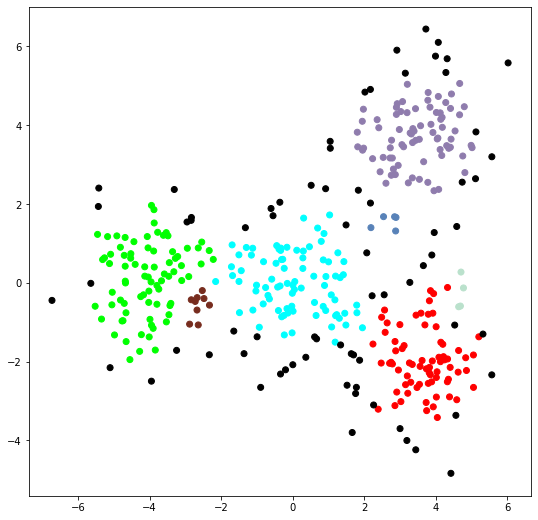

init


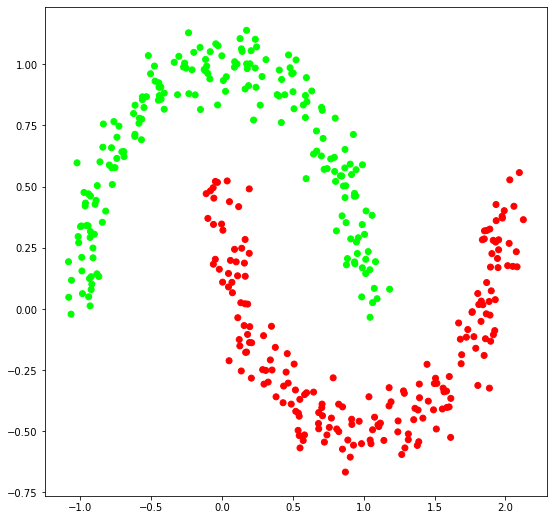

In [18]:
dbscan = DBScan()
labels = dbscan.fit_predict(X_1)
visualize_clasters(X_1, labels)

dbscan = DBScan(min_samples=10, eps=0.25)
labels = dbscan.fit_predict(X_2)
visualize_clasters(X_2, labels)

### Задание 3 (3 балла)
Идея AgglomerativeClustering заключается в том, чтобы итеративно объединять кластеры с наименьшим расстоянием между ними. Данный метод обладает высокой вычислительной сложностью, поэтому применим только для относительно небольших наборов данных.

#### Описание методов
`fit_predict(X, y=None)` для каждого элемента `X` возвращает метку кластера, к которому он относится.

#### Linkage-функции
__Linkage__ - это способ, которым будет рассчитываться расстояние между кластерами. Предлагается реализовать три варианта такой функции:
1. `average` - расстояние рассчитывается как среднее расстояние между всеми парами точек, где одна принадлежит первому кластеру, а другая - второму.
2. `single` - расстояние рассчитывается как минимальное из расстояний между всеми парами точек, где одна принадлежит первому кластеру, а другая - второму.
2. `complete` - расстояние рассчитывается как максимальное из расстояний между всеми парами точек, где одна принадлежит первому кластеру, а другая - второму.

In [19]:

class AgglomertiveClustering:
    def __init__(self, n_clusters=16, linkage="average"):
        self.n_clusters = n_clusters
        self.clusters_n = 0
        self.linkage = linkage
        self.X = None
        self.clusters = None
        self.deq = None
        self.distances = None
        self.sizes = None

    def merging_clusters(self):
        min_dist = self.distances[self.deq[0], self.deq[1]]
        i0, j0 = 0, 1
        for i in range(len(self.deq)):
            for j in range(i + 1, len(self.deq)):
                if self.distances[self.deq[i], self.deq[j]] < min_dist:
                    i0, j0 = i, j
                    min_dist = self.distances[self.deq[i], self.deq[j]]
        self.clusters_n -= 1
        n0, m0 = self.deq[i0], self.deq[j0]
        first_size = self.sizes[n0]
        other_size = self.sizes[m0]
        self.sizes[n0] += other_size
        for i in range(len(self.X)):
            if self.clusters[i] == m0:
                self.clusters[i] = n0
        for i in range(len(self.X)):
            if self.linkage == "single":
                self.distances[i][n0] = min(self.distances[i][n0], self.distances[i][m0])
            if self.linkage == "complete":
                self.distances[i][n0] = max(self.distances[i][n0], self.distances[i][m0])
            if self.linkage == "average":
                self.distances[i][n0] = (first_size * self.distances[i][n0] + other_size *
                                                   self.distances[i][m0]) / self.sizes[n0]
            self.distances[n0, i] = self.distances[i, n0]
        del self.deq[j0]

    def find(self, n, labels):
        for i in range(len(labels)):
            if labels[i] == n:
                return i
        return -1

    def fit_predict(self, X, y=None):
        self.X = X
        self.clusters_n = len(X)
        self.clusters = list(range(len(X)))
        self.sizes = [1 for i in X]
        self.distances = np.array([[np.linalg.norm(x - y) for y in self.X] for x in self.X])
        self.deq = deque(self.clusters)
        while self.clusters_n > self.n_clusters:
            self.merging_clusters()
        return [self.find(cluster, np.array(self.deq)) for cluster in self.clusters]


Протестируйте алгоритм на синтетических данных. При необходимости подберите гиперпараметры для достижения лучшего качества кластеризации.

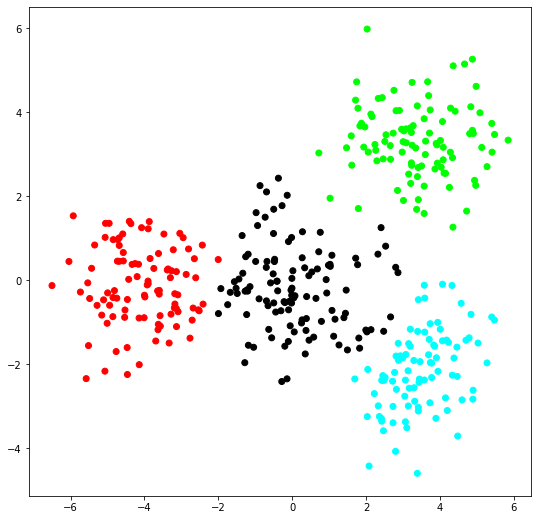

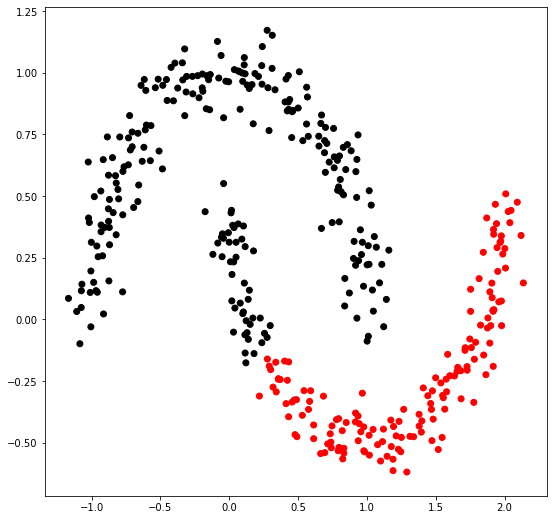

In [34]:
agg_clustering = AgglomertiveClustering(n_clusters=4)
labels = agg_clustering.fit_predict(X_1)
visualize_clasters(X_1, labels)

agg_clustering = AgglomertiveClustering(n_clusters=2)
labels = agg_clustering.fit_predict(X_2)
visualize_clasters(X_2, labels)

### Задание 4 (1 балл)
Реализуйте методы считывания и записи изображения при помощи библиотеки OpenCV. 

#### Описание методов
`read_image(path)` читает изображение и возвращает его в виде трехмерного numpy массива размера `(N, M, C)`, где `N` и `M` - размеры изображения, а `C` - количество цветов (3 для обычного изображения)
`save_image(image, path)` сохраняет изображение.

__Учтите, что `cv2.imread` считывает изображение в цветовой схеме BGR. После считывания необходимо перевести его в RGB и нормализовать__

In [ ]:
def read_image(path):
    return cv2.imread(path)[:, :, ::-1]


def show_image(image):
    plt.figure(figsize=np.array(image.shape[:-1]) / 50)
    plt.imshow(image)
    plt.axis('off')
    plt.tight_layout()
    plt.show()


def save_image(image, path):
    cv2.imwrite(path, image[:, :, ::-1])

In [ ]:
show_image(read_image("./image.png"))

### Задание 5 (1 балл)
Реализуйте функцию, которая будет кластеризовать цвета изображения одним из реализованных алгоритмов. Интерфейс этой функции можно менять. Функция должна возвращать новое изображение, в котором цвета заменены на цвета кластеров.

Затем примените ее к цветам изображения.

__Примечание: это задание проще всего выполнить при помощи KMeans__

In [23]:
def clusterize_image(image, **kwargs):
    kmeans = KMeans(15, max_iter=5, init="k-means++")
    X = []
    for row in image:
        X.extend(row)
    X = np.array(X)
    kmeans.fit(X)
    cluster_colors = np.array(kmeans.centroids)
    clusters = np.array(kmeans.predict(X))
    recolored_flatten = np.array([cluster_colors[i] for i in clusters])
    recolored = np.array([[int(round(col[0])), int(round(col[1])), int(round(col[2]))] for col in recolored_flatten]).reshape(
    (len(image), len(image[0]), 3))
    clusters_statistics(image.reshape(-1,3)/256, cluster_colors/255, clusters)  # Very slow (:
    return recolored

In [24]:
image = read_image("image.jpg")
result = clusterize_image(image)
show_image(result)

NameError: name 'read_image' is not defined